# keras里文字的操作和基于深度学习的对话模型

在本节，我们主要讨论以下几个话题：
1. keras的一些基本和进阶的操作。这是考虑到这门课之前并没有系统给大家介绍keras这个建模环境，因此为了以后学习的需要，有必要快速讲解一下基本操作和对模型对象的处理；这里会占用大约25分钟的时间
2. 在基本操作之外，我们会进一步详细讲解keras里对于文字信息的操作；这里也会占用大约25分钟的时间。
3. 最后，我们会介绍深度学习对话模型中的一个重要模型：双编码长短记忆神经网络模型（Dual Encoder LSTM NN）。在标准的模型之外我们会运用现在的一些技术，比如Attention Mechanism，Intention Mechanism等对其进行改造。这里会使用大约60分钟时间。


## keras中的一些有用概念和操作。

keras中，神经网络被模块化为各种组件，包括模型中的网络层，各种激活函数，正则化函数，优化引擎和损失函数等。

我们知道，如果要建立一个深度神经网络，最基本的要素是以下几个，其他的可以作为进一步定制的选项：
1. 输入数据的维度；
2. 模型的类型；
3. 模型中的各个网络层的类型；
4. 激活函数类型；
5. 训练模型使用的损失函数和优化引擎；

假如我们要对下图中这个神经网络建模：

![多层感知器](./images/stdMLP.png)

对照上面的要求，我们可如下以设定：
1. 输入数据的维度为（8,），即每个样本是一个8个元素的向量；
2. 模型从左到右依次操作，因此属于顺序模型：Sequential；
3. 模型中每个网络层的所有神经元都和下一个网络层的任意神经元相连，因此是一个全连接层：Dense；
4. 激活函数这里没有指明。在keras中缺省的激活函数是线性激活函数，一般只用在回归问题的最后一层，因此这里我们可以指明为其他非线性的激活函数；
5. 因为输出是一个向量，因此很可能是一个多分类模型，从而损失函数需要使用categorical_crossentropy或者categorical_hinge；优化引擎可以酌情选择；

这个模型可以非常容易地翻译为如下的keras代码：
<code>
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(8,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
</code>


## 合并神经网络

一个顺序神经网络模型在keras里非常容易构造。但是一些比较复杂的结构怎么办呢？在keras中也定义了如何来合并两个或者多个神经网络的方法，包括Add, Dot, Multiply, Concate等。

我们看下面这个简化版的深度推荐系统：

![deep Recommendation System](./images/deepRecSys.png)

这里两个不同的嵌入层会以矩阵相乘（Dot）的方法合并到一起。这种模型一般都直接申明为一个泛化模型（Model）对象：

<code>
user_in  =Input(shape=(1, ), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1)(user_in)

movie_in = Input(shape=(1, ), dtype='int64', name='movie_in')
v = Embedding(n_movies, n_factors, input_length=1)(movie_in)

x = Dot([1, 1])([u, v])
x = Flatten()(x)

model = Model(inputs = [user_in, movie_in], outputs = x)
model.compile(loss="mse", optimizer="Adam")
</code>

## model对象的操作

keras的模型对象包含非常丰富的特性和方法可以对训练后的模型中的各种元素进行操作，比如：
- 抽取模型层
- 抽取各层的权重和名称
- 定义各层是否可以被新数据训练
- 使用后台函数对各层的输入输出进行定制计算等

我们下面来针对以上操作讲解一下。

### 抽取模型层

keras的模型包含多个属性可以进行引用。假设我们已经有了一个模型，被称为model，这个模型不一定需要被训练，因为在编译模型的时候，每一层的权重都会根据一个随机函数进行初始化。这里我们暂时不详细讨论初始化的细节。

model里可以抽取以下各项特性：

- model.layers
- model.trainable_weights
- model.weights

下面一节我们通过一个使用keras展示激活函数几何特性的方式来学习这些操作。

神经网络之所以强大，与其采用非线性的激活函数不无关系。在这里，我们试图通过运用keras来展示和分析激活函数从而让同学们同时了解keras的一些奇妙用法。
1. 首先，我们采用keras来生成不同激活函数的表达，并以图形的形式展示出来。
2. 然后，我们通过分析keras的源代码来演示如何生成自己自定义的激活函数。


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import gc
from keras.layers import Dense, Activation
from keras.models import Sequential

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16, 10)

Using TensorFlow backend.


In [2]:
x = (np.arange(200)-100)/100
y = -np.log(x+101/100)

model = Sequential()
model.add(Dense(1, input_shape=(1,), activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model.fit(x, x, epochs=1, batch_size=128, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
200/200 [==============================] - 1s 4ms/step - loss: 0.4510 - mean_absolute_error: 0.4510


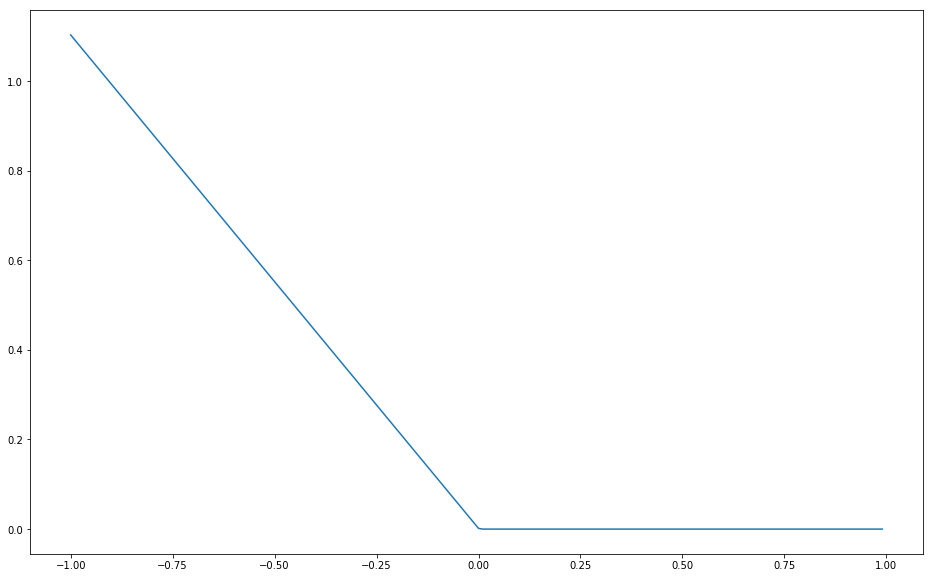

In [3]:
from keras import backend as K

inp = model.input                                           # 输入
outputs = [layer.output for layer in model.layers]          # 抓取各个网络层，实际这里最关键的只有激活层
functions = [K.function([inp], [out]) for out in outputs]    # K.function()使用tenforflow后台初始化一个计算函数

# 验证结果
activationLayer={}
for i in range(x.shape[0]):
    test = x[i].reshape(-1, 1)
    layer_outs = [func([test]) for func in functions]
    activationLayer[i] = layer_outs[0][0][0][0]
    
activationDf = pd.DataFrame.from_dict(activationLayer, orient='index')
plt.plot(x, activationDf)   
plt.show()

In [4]:
def NNmodel(activationFunc='linear'):
    '''
       定义一个神经网络模型。如果要定义不同的模型，可以直接修改该函数
    '''
    model = Sequential()
    model.add(Dense(1, input_shape=(1,), activation=activationFunc))
        
    model.add(Dense(1, activation='linear'))
    #model.summary()
    model.compile(loss='mse', optimizer='adagrad', metrics=['mse'])
    return model

def VisualActivation(activationFunc='relu', plot=True):    
    x = (np.arange(100)-50)/10
    y = np.log(x+51/10)
    
    model = NNmodel(activationFunc = activationFunc)
    model.fit(x, x, epochs=1, batch_size=128, verbose=0)
    
    inX = model.input                                          
    outputs = [layer.output for layer in model.layers]     
    functions = [K.function([inX], [out]) for out in outputs]   
    
    activationLayer={}
    for i in range(100):
        test = x[i].reshape(-1, 1)
        layer_outs = [func([test]) for func in functions]
        activationLayer[i] = layer_outs[0][0][0][0]
        
    activationDf = pd.DataFrame.from_dict(activationLayer, orient='index')
    result=pd.concat([pd.DataFrame(x), activationDf], axis=1)
    result.columns=['X', 'Activated']
    result.set_index('X', inplace=True)
    if plot:
        result.plot(title=f)
    
    return result


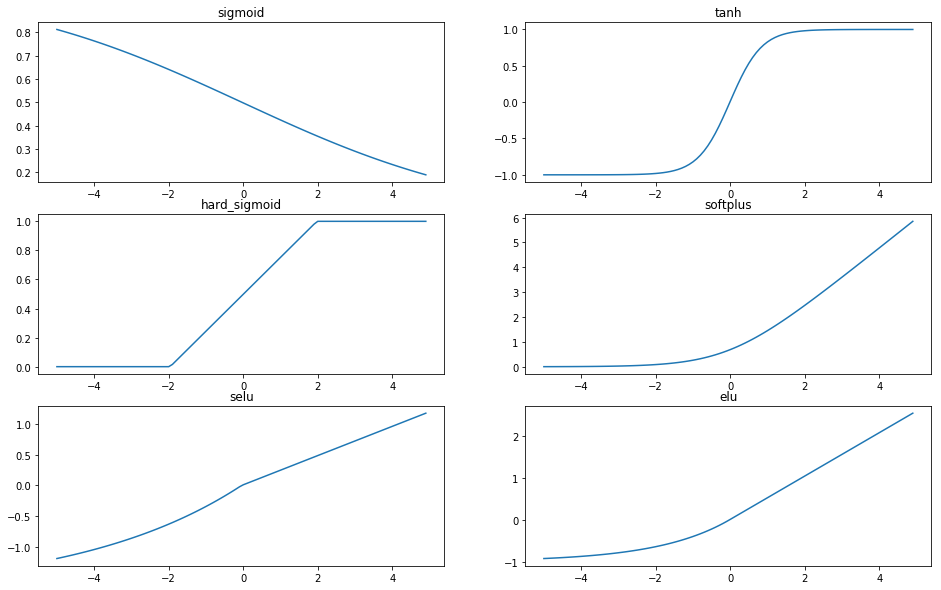

In [5]:
actFuncs = ['sigmoid', 'tanh', 'hard_sigmoid', 'softplus', 'selu', 'elu']

from keras.layers import LeakyReLU
figure = plt.figure()
for i, f in enumerate(actFuncs):
    # 依次画图
    figure.add_subplot(3, 2, i+1)
    out=VisualActivation(activationFunc=f, plot=False)
    plt.plot(out.index, out.Activated)
    plt.title(f)


从上面的操作我们可以学习到以下知识点：
1. 一个模型就是一个对象，其包含多个属性可供分析师抽取，进行进一步的分析和操作，比如抽取权重画图；
2. 可以通过后台函数K.function()来定义对输入数据在每一层进行计算，从而可以进一步分析每一步的运算特性；
3. 中间层计算结果输出是一个列表，因此非常容易查看输出的结构，并进行相应的操作；

## keras里对文字的操作

下面我们专门针对文字信息考察keras里面提供的操作。

文本数据的处理主要是在解析和标注上，根据需要操作的对象不同，方法也有不同。这里我们按照文字分为英文和中文两种；同时按照输入数据是单一文件还是多个文件分为两种情况。因为这两类情景相互独立，因此我们分别介绍。

首先我们介绍英文单一文本的处理。对于英文的单一文本列表，keras提供了text_to_word_sequence这个函数，可以将字符串类型一句话分裂为单词。听起来简单，但是在实际操作中有很多选项会产生完全不同的结果。下面演示一下。

我们先调入所需的库。

In [6]:
import os, gc, sys
import keras
from keras.preprocessing import text
from keras import utils

In [7]:
input="Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, \
       CNTK, or Theano."
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
result = text.text_to_word_sequence(input,
                                    filters='a',
                                    lower=True,
                                    split=" ")
print(result)

['ker', 's', 'is', 'high-level', 'neur', 'l', 'networks', 'pi,', 'written', 'in', 'python', 'nd', 'c', 'p', 'ble', 'of', 'running', 'on', 'top', 'of', 'tensorflow,', 'cntk,', 'or', 'the', 'no.']


这个方法里，lower选项就是指将输入的字符转换成小写字符处理并输出，只对英文有效。这里需要详细讲讲filters和split这两个选项：
- filters 这个选项对一个列表里的字符进行过滤，就是在这个列表里的字符都会被过滤掉。这里中英文字符都可以放入过滤字符列表中起作用，下面的例子做了展示；
- split 这个选项对句子的解析至关重要。输入要求是一个字符串，这个方法使用该字符串对输入的长字符串进行切分。在英文中使用空格符就好，但是在中文这种没有分隔符的语言中就不行，需要使用中文的专用切分工具，比如jieba等来处理。同学们也可以先使用该方法的过滤器对中英文字符进行过滤后再应用jieba分词工具。

在Anaconda环境下安装jieba，特别是在Python3的环境下安装jieba3k这个针对Python 3.x环境的分词包，可以使用如下命令：
<code>
conda install -c conda-forge jieba3k 
</code>

In [8]:
input="Keras是一个高度抽象的神经网络API，以Python写成，可以TensorFlow，CNTK或者Theano为计算后台运行"
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\nABCDEFGHIJKLMENOPQRSTUVWXYZ行'
result = text.text_to_word_sequence(input,
                                    filters=filters,
                                    lower=False,
                                    split=",")
print(result)

['eras是一个高度抽象的神经网络', '，以', 'ython写成，可以', 'ensor', 'low，', '或者', 'heano为计算后台运']


可以看到keras的工具是为英文设计的，不能正常解析中文文本。这里我们简要介绍如何使用结巴分词来进行操作。

根据jieba分词库的自我介绍，其支持三种分词模式：
- 精确模式，试图将句子最精确地切开，适合文本分析，也是最常用的。该模式对应jieba.cut方法，使用cut_all=False选项
- 全模式，把句子中所有的可以成词的词语都扫描出来, 速度非常快而且颗粒度非常高，但是不能解决歧义，比如“...川普通过...”会被切分为“川普”，“普通”等多个词，但是这里实际上只有“川普”这个词有意义。该模式也对应jieba.cut方法，使用cut_all=True选项
- 搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。该模式对应jieba.cut_for_search方法。

在jieba3k中，以上两种方法都返回一个可迭代的生成器（generator）对象，可以使用for 循环来获取分割后的单词。

在老版本的jieba.cut和jieba.cut_for_search各自对应一个返回列表的函数，分别是lcut 和lcut_for_search，其用法一样，只是返回数据类型是一个列表，但是在jieba3k中似乎没有这些方法了。

In [9]:
import jieba

In [10]:
chn='此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借"通灵 \
"之说，撰此《石头记》一书也。故曰"甄士隐"云云．但书中所记何事何人？自又 \
云：“今风尘碌碌，一事无成，忽念及当日所有之女子，一一细考较去，觉其行止见 \
识，皆出于我之上．何我堂堂须眉，诚不若彼裙钗哉？实愧则有余，悔又无益之大无可 \
如何之日也！当此，则自欲将已往所赖天恩祖德，锦衣纨绔之时，饫甘餍肥之日，背父 \
兄教育之恩，负师友规谈之德，以至今日一技无成，半生潦倒之罪，编述一集，以告天 \
下人：我之罪固不免，然闺阁中本自历历有人，万不可因我之不肖，自护己短，一并使 \
其泯灭也．虽今日之茅椽蓬牖，瓦灶绳床，其晨夕风露，阶柳庭花，亦未有妨我之襟怀 \
笔墨者．虽我未学，下笔无文，又何妨用假语村言，敷演出一段故事来，亦可使闺阁昭 \
传，复可悦世之目，破人愁闷，不亦宜乎？故曰"贾雨村"云云。'

chnout1 = jieba.cut(chn, cut_all=False)
chnoutlist1 = [x for x in chnout1]
print(len(chnoutlist1), [x for x in chnoutlist1[:15]])

chnout2 = jieba.cut(chn, cut_all=True)
chnoutlist2 = [x for x in chnout2]
print(len(chnoutlist2), [x for x in chnoutlist2[:25]])

chnout3 = jieba.cut(chn, cut_all=True, HMM=True)
chnoutlist3 = [x for x in chnout3]
print(len(chnoutlist3), [x for x in chnoutlist3[35:50]])

chnout4 = jieba.cut_for_search(chn, HMM=False)
chnoutlist4 = [x for x in chnout4]
print(len(chnoutlist3), [x for x in chnoutlist3[35:50]])

Building prefix dict from D:\Anaconda3\lib\site-packages\jieba\dict.txt ...
Loading model from cache C:\Users\xieliang\AppData\Local\Temp\jieba.cache
Loading model cost 0.8951783180236816 seconds.
Prefix dict has been built succesfully.


248 ['此', '开卷', '第一回', '也', '。', '作者', '自云', '：', '因曾', '历过', '一番', '梦幻', '之后', '，', '故']
361 ['此', '开卷', '第一', '第一回', '一回', '也', '', '', '作者', '自', '云', '', '', '因', '曾', '历', '过', '一番', '梦幻', '之后', '', '', '故', '将', '真事']
361 ['', '', '之说', '', '', '撰', '此', '', '', '石头', '石头记', '', '', '一', '书']
361 ['', '', '之说', '', '', '撰', '此', '', '', '石头', '石头记', '', '', '一', '书']


对于大批量的文本文件，当需要同意进行处理的时候，keras提供了一个非常方便的类称为：Tokenizer，可以对多个文档以列表元素形式存在的对象进行统一操作。这个方法一般应用在一次性批量读入多个文本文件以后，提供的方法有：
- fit_on_texts(texts)。该方法对于一个文本列表进行拟合，拟合的目的是为了获得以下的关键统计量：
- texts_to_sequences(texts)，同时有个与生成器对象对应的texts_to_sequences_generator(texts)方法，该方法将文本列表数据转化为以单词索引下标为元素的列表，从而才能供之后的数据建模使用。
- texts_to_matrix(texts)，与上面的方法类似，只是生成数据直接就是一个按照单词索引下标构造的巨大的矩阵
- fit_on_sequences(sequences)
- sequences_to_matrix(sequences)

下面我们来看看实例，该实例来自于keras的官方博客，但是我将一些不是重点的查错逻辑删掉，这样能更容易看清其处理步骤和逻辑。

In [11]:
%%time

TEXT_DATA_DIR = './data/20_newsgroup'
texts = []  # 用于存储文本的列表
labels_index = {}  # 子目录列表词典，因为每个子目录都是一类对应的文字，所以被称为label
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):  # 按照路径名排序读入文件夹下的所有子目录
    path = os.path.join(TEXT_DATA_DIR, name)    # 构造完整的路径名
    label_id = len(labels_index)
    labels_index[name] = label_id
    for fname in sorted(os.listdir(path)):   #按照文件名依次读入文件夹下所有文本文件
        fpath = os.path.join(path, fname) # 构造完整文件路径名
        f = open(fpath, encoding='latin-1')
        t = f.read()                      # 一次性读入整个文本文件
        i = t.find('\n\n')  # 跳过文件头
        if i > 0:
            t = t[i:]
        texts.append(t)
        f.close()
        labels.append(label_id)

print('Found %s texts in %s categories' % (len(texts), len(labels_index)))

Found 19997 texts in 20 categories
Wall time: 1.84 s


来看看每篇文章的字数长度：

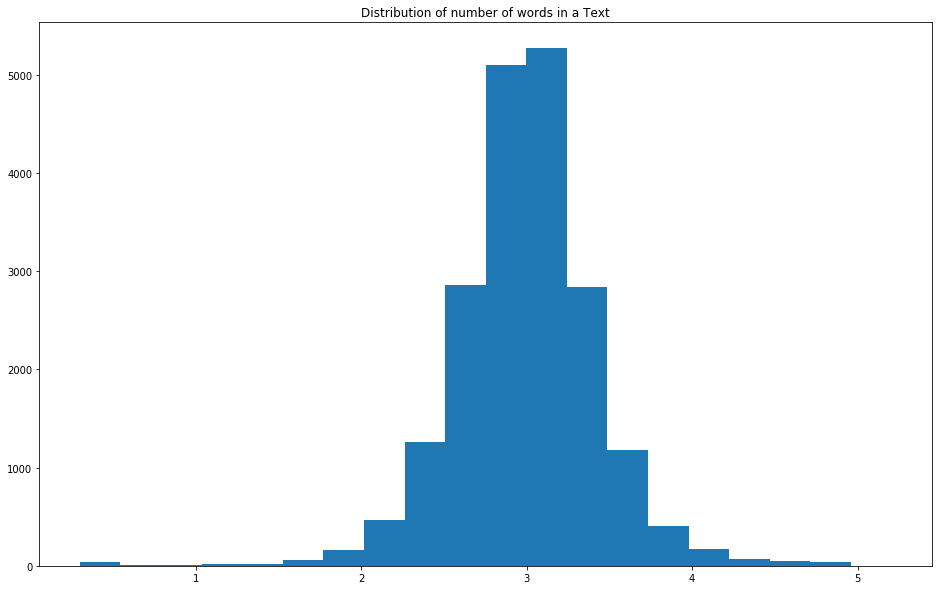

In [12]:
textsLength = list(map(len, texts))
plt.hist(np.log10(textsLength), bins=20)
# pyplot里似乎对中文支持不好
plt.title("Distribution of number of words in a Text")
plt.show()

In [13]:
MAX_NB_WORDS= None # 该选项如果设定为一个整数，那么Tokenizer只输出前N个最常见的单词的相关信息，如果是None则对所有单词进行处理
MAX_SEQUENCE_LENGTH = 50  #最长句子长度，可以为中位值或者其他合适的值。

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [14]:
print(len(sequences))
for j in range(3):
    print(sequences[j+1][:10])

19997
[1237, 273, 1213, 3140, 1071, 1213, 1237, 273, 3140, 192]
[6, 54, 84488, 10754, 1731, 26, 8090, 201, 1731, 26]
[19952, 19953, 13458, 26, 421, 2505, 670, 13139, 22, 13139]


In [15]:
%%time
textsMatrix = tokenizer.texts_to_matrix(texts)
print(textsMatrix.shape)

(19997, 174075)
Wall time: 4.93 s


In [16]:
textsMatrix.dtype
del(textsMatrix)

但是对于中文，这个标注类就没有那么方便了，因为其文本解析是针对英文来的，对于中文依旧无法进行正确的分词。这时候需要采用jieba分词先进行分词，在自行构造索引，我们可以仿造标注类里面的函数依样画葫芦，构造自己的中文标注类。主要差别是在读入每一份文本之后，使用结巴分词进行分词，而不是按照空格符进行分词，分词之后，其他的操作就可以依照标注类的动作进行了。

### 小结

以上的讲解都说明，学习一种编程工具的最好办法就是看源代码，并尝试改进。

## 基于深度学习的双编码长短记忆对话模型

下一节里我们将构造双编码长短记忆（Dual Encoder LSTM）对话模型，并且引入attention以及bidirectional LSTM来改造原有的模型。

双编码长短记忆模型是一种被证明比较有效的进行对话建模的模型，被成功应用在Ubuntu对话集$^{[1]}$，保险问答对话集$^{[2]}$等。

### Embedding 嵌入

在几乎所有的文字建模中，都会用到嵌入这种技术（Embedding）。一般keras用户会直接使用嵌入层 Embedding()对输入的标注后文本索引数据进行映射。但是embedding层几乎肯定的是使用预先训练好的word2vec或者GloVe模型的权重，这并不一定适合当前的环境，尤其是建模对象为中文的时候。这时需要自己构造自己的嵌入权重。我在这里只会简单介绍一下如何运用wiki中文的语料库通过gensim这个库构造自己的嵌入权重，同学们可以自己试试不同的语料库来感受一下。

无论是中文还是英文，wiki dump的文件都是bz2格式，需要先通过**gensim**的WikiCorpus函数来抽取。下面是英文版本，中文的样例是一样的，只是作用的文本数据不一样，但是大家可以看看不同的写法。该步骤耗时较长。

In [17]:
import multiprocessing
import sys, os, logging, codecs
import gensim
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.word2vec import Word2Vec, LineSentence

D:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [18]:
wiki = WikiCorpus('./data/enwiki-latest-pages-articles.xml.bz2', 
                  lemmatize=False, dictionary={})
#sentences = list(wiki.get_texts())
output = open('./data/en_wiki.text', 'w', encoding='utf-8')
for text in wiki.get_texts():
    output.write(" ".join(text) + '\n')
output.close()
del(wiki)
print("Finishing extractoing texts...")
# 现在建模
infile = './data/en_wiki.text'
params = {'size': 200, 'window': 5, 'min_count': 10, 
          'workers': multiprocessing.cpu_count(), 'sg': 1,
          'sample': 1E-3,}
word2vec = Word2Vec(LineSentence(infile), **params)
print('Finishing building word2vec model using English Wiki....')

Finishing extractoing texts...
Finishing building word2vec model using English Wiki....


In [19]:
outfile = './data/enwiki.word2vec.model'
word2vec.save(outfile)
word2vec.wv.save_word2vec_format(outfile + '.vector', binary=False)

In [20]:
del(word2vec)
gc.collect()

0

模仿上面的代码，我们也可以训练自己的中文维基语料库构造自己的嵌入权重。下面这两段代码分别来由自于[这个网址](https://flystarhe.github.io/2016/09/04/word2vec-test/)和[这个网址](https://flystarhe.github.io/2016/08/31/wiki-corpus-zh/)的代码构造的。读者其实根据上面的英文维基处理代码也能写出一样的代码。

首先从bz2文件中读出文本。

In [21]:

#sys.setdefaultencoding('utf-8')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
infile = './data/zhwiki-latest-pages-articles.xml.bz2'
outfile = './data/wikicn.text'

wiki = WikiCorpus(infile, lemmatize=False, dictionary={})

output = codecs.open(outfile, 'w', 'utf-8')
for text in wiki.get_texts():
    output.write(" ".join(text) + '\n')
output.close()

2017-12-21 11:48:08,369 : INFO : finished iterating over Wikipedia corpus of 280819 documents with 62921777 positions (total 2893828 articles, 75220572 positions before pruning articles shorter than 50 words)


其次，我们可以使用gensim根据中文维基语料构造自己的映射权重。

In [22]:
%%time

infile = './data/wiki.cn.txt'
outfile = './data/wiki.cn.model'
params ={'size' : 400, 'window' : 5, 'min_count':10, 
         'sg':1, # 使用skipgram，生成400维的映射
         'workers' : multiprocessing.cpu_count()}
model = Word2Vec(LineSentence(infile), **params)
model.save(outfile)
model.wv.save_word2vec_format(outfile + '.vector', binary=False)

2017-12-21 11:48:08,573 : INFO : collecting all words and their counts
2017-12-21 11:48:08,573 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-21 11:48:10,695 : INFO : PROGRESS: at sentence #10000, processed 4045155 words, keeping 2445673 word types
2017-12-21 11:48:12,382 : INFO : PROGRESS: at sentence #20000, processed 7056276 words, keeping 4042878 word types
2017-12-21 11:48:13,821 : INFO : PROGRESS: at sentence #30000, processed 9815770 words, keeping 5375232 word types
2017-12-21 11:48:15,445 : INFO : PROGRESS: at sentence #40000, processed 12411710 words, keeping 6575971 word types
2017-12-21 11:48:16,726 : INFO : PROGRESS: at sentence #50000, processed 14882639 words, keeping 7655482 word types
2017-12-21 11:48:17,988 : INFO : PROGRESS: at sentence #60000, processed 17284347 words, keeping 8648957 word types
2017-12-21 11:48:19,207 : INFO : PROGRESS: at sentence #70000, processed 19516570 words, keeping 9582049 word types
2017-12-21 11:48:20,4

2017-12-21 11:49:37,384 : INFO : PROGRESS: at 5.03% examples, 226506 words/s, in_qsize 12, out_qsize 1
2017-12-21 11:49:38,415 : INFO : PROGRESS: at 5.17% examples, 226391 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:49:39,425 : INFO : PROGRESS: at 5.33% examples, 226619 words/s, in_qsize 13, out_qsize 0
2017-12-21 11:49:40,487 : INFO : PROGRESS: at 5.50% examples, 226474 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:49:41,495 : INFO : PROGRESS: at 5.65% examples, 226749 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:49:42,510 : INFO : PROGRESS: at 5.82% examples, 226913 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:49:43,523 : INFO : PROGRESS: at 5.97% examples, 226850 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:49:44,523 : INFO : PROGRESS: at 6.12% examples, 226981 words/s, in_qsize 14, out_qsize 0
2017-12-21 11:49:45,648 : INFO : PROGRESS: at 6.28% examples, 226818 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:49:46,667 : INFO : PROGRESS: at 6.43% examples, 227149 word

2017-12-21 11:50:59,266 : INFO : PROGRESS: at 17.58% examples, 233900 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:51:00,290 : INFO : PROGRESS: at 17.75% examples, 233969 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:51:01,353 : INFO : PROGRESS: at 17.90% examples, 234012 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:51:02,352 : INFO : PROGRESS: at 18.05% examples, 234196 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:51:03,383 : INFO : PROGRESS: at 18.21% examples, 234157 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:51:04,399 : INFO : PROGRESS: at 18.38% examples, 234235 words/s, in_qsize 14, out_qsize 0
2017-12-21 11:51:05,397 : INFO : PROGRESS: at 18.50% examples, 234283 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:51:06,428 : INFO : PROGRESS: at 18.65% examples, 234410 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:51:07,447 : INFO : PROGRESS: at 18.79% examples, 234404 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:51:08,478 : INFO : PROGRESS: at 18.96% examples, 2

2017-12-21 11:52:19,866 : INFO : PROGRESS: at 29.40% examples, 235409 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:52:20,882 : INFO : PROGRESS: at 29.56% examples, 235402 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:52:21,901 : INFO : PROGRESS: at 29.74% examples, 235434 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:52:22,917 : INFO : PROGRESS: at 29.89% examples, 235433 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:52:23,927 : INFO : PROGRESS: at 30.04% examples, 235455 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:52:24,942 : INFO : PROGRESS: at 30.17% examples, 235504 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:52:25,947 : INFO : PROGRESS: at 30.33% examples, 235540 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:52:26,978 : INFO : PROGRESS: at 30.52% examples, 235532 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:52:28,041 : INFO : PROGRESS: at 30.70% examples, 235542 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:52:29,063 : INFO : PROGRESS: at 30.85% examples, 2

2017-12-21 11:53:40,383 : INFO : PROGRESS: at 41.70% examples, 238053 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:53:41,383 : INFO : PROGRESS: at 41.84% examples, 238064 words/s, in_qsize 14, out_qsize 0
2017-12-21 11:53:42,414 : INFO : PROGRESS: at 41.99% examples, 238046 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:53:43,424 : INFO : PROGRESS: at 42.11% examples, 238041 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:53:44,440 : INFO : PROGRESS: at 42.26% examples, 238067 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:53:45,453 : INFO : PROGRESS: at 42.40% examples, 238071 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:53:46,453 : INFO : PROGRESS: at 42.55% examples, 238070 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:53:47,463 : INFO : PROGRESS: at 42.70% examples, 238095 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:53:48,463 : INFO : PROGRESS: at 42.84% examples, 238078 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:53:49,510 : INFO : PROGRESS: at 43.00% examples, 2

2017-12-21 11:55:00,698 : INFO : PROGRESS: at 54.25% examples, 239462 words/s, in_qsize 12, out_qsize 0
2017-12-21 11:55:01,726 : INFO : PROGRESS: at 54.43% examples, 239488 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:55:02,757 : INFO : PROGRESS: at 54.57% examples, 239687 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:55:03,763 : INFO : PROGRESS: at 54.73% examples, 239777 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:55:04,779 : INFO : PROGRESS: at 54.90% examples, 239808 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:55:05,779 : INFO : PROGRESS: at 55.06% examples, 239831 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:55:06,786 : INFO : PROGRESS: at 55.24% examples, 239857 words/s, in_qsize 12, out_qsize 0
2017-12-21 11:55:07,786 : INFO : PROGRESS: at 55.41% examples, 239859 words/s, in_qsize 14, out_qsize 0
2017-12-21 11:55:08,853 : INFO : PROGRESS: at 55.57% examples, 239842 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:55:09,884 : INFO : PROGRESS: at 55.74% examples, 2

2017-12-21 11:56:21,229 : INFO : PROGRESS: at 66.41% examples, 240571 words/s, in_qsize 13, out_qsize 0
2017-12-21 11:56:22,244 : INFO : PROGRESS: at 66.58% examples, 240558 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:23,263 : INFO : PROGRESS: at 66.72% examples, 240628 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:56:24,294 : INFO : PROGRESS: at 66.87% examples, 240636 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:25,289 : INFO : PROGRESS: at 67.02% examples, 240643 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:26,305 : INFO : PROGRESS: at 67.16% examples, 240668 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:27,321 : INFO : PROGRESS: at 67.33% examples, 240699 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:28,365 : INFO : PROGRESS: at 67.48% examples, 240713 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:29,365 : INFO : PROGRESS: at 67.65% examples, 240724 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:56:30,387 : INFO : PROGRESS: at 67.83% examples, 2

2017-12-21 11:57:41,497 : INFO : PROGRESS: at 79.29% examples, 242036 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:57:42,498 : INFO : PROGRESS: at 79.49% examples, 242038 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:43,514 : INFO : PROGRESS: at 79.67% examples, 242049 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:44,537 : INFO : PROGRESS: at 79.87% examples, 242084 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:45,537 : INFO : PROGRESS: at 80.02% examples, 242095 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:46,541 : INFO : PROGRESS: at 80.10% examples, 242080 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:47,556 : INFO : PROGRESS: at 80.21% examples, 242065 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:48,557 : INFO : PROGRESS: at 80.31% examples, 242057 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:49,590 : INFO : PROGRESS: at 80.44% examples, 242041 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:57:50,621 : INFO : PROGRESS: at 80.55% examples, 2

2017-12-21 11:59:02,127 : INFO : PROGRESS: at 91.49% examples, 242380 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:59:03,145 : INFO : PROGRESS: at 91.62% examples, 242415 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:59:04,161 : INFO : PROGRESS: at 91.80% examples, 242418 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:59:05,176 : INFO : PROGRESS: at 91.98% examples, 242433 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:59:06,179 : INFO : PROGRESS: at 92.13% examples, 242437 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:59:07,210 : INFO : PROGRESS: at 92.29% examples, 242432 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:59:08,215 : INFO : PROGRESS: at 92.44% examples, 242439 words/s, in_qsize 15, out_qsize 0
2017-12-21 11:59:09,231 : INFO : PROGRESS: at 92.61% examples, 242445 words/s, in_qsize 16, out_qsize 0
2017-12-21 11:59:10,242 : INFO : PROGRESS: at 92.79% examples, 242464 words/s, in_qsize 13, out_qsize 0
2017-12-21 11:59:11,289 : INFO : PROGRESS: at 92.97% examples, 2

Wall time: 12min 54s


In [23]:
del(model)
gc.collect()

0

介绍了这些必备知识以后我们需要根据双编码长短记忆模型来构造我们的对话模型。这里我们执行一个完整的建模流程，包括：
1. 原始数据的读入。这里原始数据已经通过标注类的运算，将原来的文本单词替换为单词索引下标。
2. 原始数据的处理。这里需要将原来的一来一往的对话构造成单独两人之间的多伦对话，其构造的模式如下图所示：
![构造多轮对话](./images/MultiTurnDialog.png)
3. 在keras中构造双编码长短记忆模型
4. 使用 ***recall@N*** 来验证模型效果，并与TFIDF模型结果进行比较。

其中，基本的数据操作都来自于[原作者网站](https://github.com/rkadlec/ubuntu-ranking-dataset-creator)。

In [24]:
import unicodecsv, csv

我们先来看看原始数据的构成

In [25]:
dialog_end_symbol = "__dialog_end__"
end_of_utterance_symbol = "__eou__"
end_of_turn_symbol = "__eot__"

dialog_filename = './data/dataset_1MM/ubuntu_dialogs'
counter = 0
with open(dialog_filename, 'r', encoding='utf-8') as infile:
    for line in infile:
        if counter>1:
            print(line.split('\t'))
        counter += 1
        if counter > 15:
            break

['2012-08-27T05:54:00.000Z', 'Adie', '', "it's weird\n"]
['2012-08-27T05:54:00.000Z', 'Adie', '', 'ANVE YOU EVER SEEN SCREENS INTERSECTING? D:\n']
['2012-08-27T05:55:00.000Z', 'Adie', '', "It's a 6970\n"]
['2012-08-27T05:55:00.000Z', 'Adie', '', 'I enabled all three displays via CCC\n']
['2012-08-27T05:55:00.000Z', 'Adie', '', 'http://i.imgur.com/y2jrV.png\n']
['2012-08-27T05:55:00.000Z', 'Adie', '', "that's what I end up with\n"]
['2012-08-27T05:55:00.000Z', 'Adie', '', "it's *funny*, but not what I want\n"]
['2012-08-27T05:55:00.000Z', 'Adie', '', 'lol\n']
['2012-08-27T05:55:00.000Z', 'trevorj', 'Adie', 'sae card as me, nie\n']
['2012-08-27T05:56:00.000Z', 'trevorj', 'Adie', 'whats this picture of\n']
['2012-08-27T05:56:00.000Z', 'trevorj', 'Adie', 'two monitors?\n']
['2012-08-27T05:56:00.000Z', 'trevorj', 'Adie', 'wheres the third?\n']
['2012-08-27T05:56:00.000Z', 'trevorj', 'Adie', "how did you connect the three screens? Does X see all three screens? (ie run 'xrandr' and see what o

In [26]:
%%time 
# go through the dialog
first_turn = True
dialog = []
same_user_utterances = []

last_user = None
dialog.append(same_user_utterances)

#读入数据
counter = 0
with open(dialog_filename, 'r', encoding='utf-8') as infile:
    for line in infile:            
        terms = line.split('\t')
        if  (len(terms)>1) & (first_turn):
            last_user = terms[1]
            first_turn = False

        if (len(terms)>1):
            if (last_user != terms[1]):
                # user has changed
                same_user_utterances = []
                dialog.append(same_user_utterances)
            
        if len(terms)>=2:
            if len(terms)>=4:
                same_user_utterances.append(terms[3])
            last_user = terms[1]
        
        counter += 1

    dialog.append([dialog_end_symbol])

Wall time: 31.6 s


现在再来看看加工后的数据内容。现在的数据已经将属于同一个用户在同一个话题下的讨论装在一起了。

In [27]:
dialog[1:2]

[['sae card as me, nie\n',
  'whats this picture of\n',
  'two monitors?\n',
  'wheres the third?\n',
  "how did you connect the three screens? Does X see all three screens? (ie run 'xrandr' and see what outputs it sees)\n",
  'oh shit\n',
  "they do intersect don't they\n",
  "that's a fun one ;)\n",
  'which one is on the right\n',
  'I figured so much!\n',
  'can you pastebin the output of xrandr\n',
  'what error?\n',
  'and from what?\n',
  "ah, from gnome-control-center's display applet?\n",
  'what error?\n']]

下面的代码按照一定的概率，从正确的应对和随机挑选的应对与当前的上下文进行配对，如果使用的是正确应对，就赋予正样本标注，否则是负样本标注。

In [28]:
def create_single_dialog_train_example(context_dialog_path, candidate_dialog_paths, rng, positive_probability,
                                       minimum_context_length=2,max_context_length=20):

    dialog = translate_dialog_to_lists(context_dialog_path)
    context_str, next_utterance_ix = create_random_context(dialog, rng,
                                                           minimum_context_length=minimum_context_length,
                                                           max_context_length=max_context_length)

    if positive_probability > rng.random():
        # use the next utterance as positive example
        response = singe_user_utterances_to_string(dialog[next_utterance_ix])
        label = 1.0
    else:
        response = get_random_utterances_from_corpus(candidate_dialog_paths,rng,1,
                                                     min_turn=minimum_context_length+1,
                                                     max_turn=max_context_length)[0]
        label = 0.0
    return context_str, response, label

In [29]:
def create_random_context(dialog,rng,minimum_context_length=2,max_context_length=20):
    max_len = min(max_context_length, len(dialog)) - 2
    if max_len <= minimum_context_length:
        context_turns = max_len
    else:
        context_turns = rng.randint(minimum_context_length,max_len)
    return dialog_turns_to_string(dialog[:context_turns]),context_turns

def singe_user_utterances_to_string(utterances_list):
    return " ".join(map(lambda x: x+" "+ end_of_utterance_symbol, utterances_list))

当然我们在下面的演示中使用的是将上述过程跑完之后存为一个pickle文件的结果，这是为了保证建模所需的数据跟原有数据尽可能一致。在下面的章节里，我们依次进行如下操作：
1. 先载入所需的库
2. 展示双编码长短记忆模型的结构
3. 在keras中实现这个结构，并拟合模型
4. 考察 recall@K 的效果。这个需要对除开最后输出层的其它层进行运算，代码仿造上面关于抽取模型层的介绍。
5. 我们会展示基本模型的两个拓展：
   1. 双向LSTM
   2. Attention 机制

首先载入所需的库。

In [30]:
import pickle

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Embedding, Reshape, Dot, Concatenate, Multiply, Merge, Bidirectional
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json

from sklearn.preprocessing import MinMaxScaler

读入数据。这里我们直接读入二进制的pickle文件。

In [31]:
%%time
with open("./data/dataset_1MM/dataset.pkl", "rb") as f:
    data = pickle.load(f)

Wall time: 15.3 s


看看数据里都是什么

In [32]:
for j in range(len(data)):
    print("======= %s" % j)
    for i, k in enumerate(data[j]):
        print(k)

======= 0
y
c
r
======= 1
y
c
r
======= 2
y
c
r


In [33]:
np.array(data[0]['r'][:2])

array([list([30732]),
       list([98971, 107411, 31729, 68782, 13159, 61319, 140905, 96690, 25464, 98971, 3718, 129994, 91830, 33603, 61319, 70208, 39897, 99600, 70250, 61319, 132630, 70208])], dtype=object)

In [34]:
import gc
gc.collect()

150

这里分析最长的句子的长度

In [35]:
# 这里分析最长的句子的长度
length=map(len, data[0]['c'])
res=list(length)
context_length=np.max(res[:])
print(context_length)

length=map(len, data[0]['r'])
res=list(length)
response_length=np.max(res[:])
print(response_length)

2002
939


这里分析整个词典的大小

In [36]:
%%time

# 这里分析整个词典的大小
context_size = np.max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['c'])))
print("Context Max Id: %s" % context_size)

response_size = max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['r'])))
print("Response Max Id: %s" % response_size)

Context Max Id: 144952
Response Max Id: 144952
Wall time: 3.23 s


我们来看看双编码长短记忆模型的结构：
![DualEncoderLSTM](./images/DualEncoderLSTM.png)

在这里，encoder和decoder都是LSTM里通常的意思。但是在实际建模的时候，分析师通常有两种选择，一种是直接对原始索引下标所代表的原始数据空间进行编码解码的工作，另外更常见的是先做嵌入，将建模的维度大大缩小以后再纳入LSTM进行训练。在这里显然先进行嵌入是一个明智的选择，因为原始空间的维度超过14万。

现在我们对上述模型编写代码。在keras里，针对这种非顺序的结构，一般采用范式模型（Model）对象。

In [37]:
embedding_dim=64
lstm_dim=64

context_length=np.max(list(map(len, data[0]['c'])))
#print(context_length)
response_length=np.max(list( map(len, data[0]['r'])))
#print(response_length)
context_length=120


Y = data[0]['r']

print('Begin Modeling...')

context_size = np.max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['c'])))
response_size = max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['r'])))
volcabulary_size=max(context_size, response_size)


# 对上下文部分进行嵌入和建模
context=Input(shape=((context_length,)), name='context_input')
context_embedded=Embedding(input_length=context_length, output_dim=embedding_dim, 
                           input_dim=volcabulary_size, name='context_embedding')(context)
context_lstm=LSTM(lstm_dim, name='context_lst')(context_embedded)

# 对回应部分进行嵌入和建模
response_length=120
response=Input(shape=((response_length,)), name='response_input')
response_embedded=Embedding(input_length=response_length, output_dim=embedding_dim, 
                            input_dim=volcabulary_size, name='response_embedding')(response)
response_lstm=LSTM(lstm_dim, name='response_lstm')(response_embedded)

x = Dot([1, 1], name='Merged')([context_lstm, response_lstm])
yhat = Dense(2, activation='softmax', name='output')(x)

model = Model(inputs=[context, response], outputs=yhat)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('Finish compiling...')
model.summary()

Begin Modeling...
Finish compiling...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      (None, 120)          0                                            
__________________________________________________________________________________________________
response_input (InputLayer)     (None, 120)          0                                            
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 120, 64)      9276928     context_input[0][0]              
__________________________________________________________________________________________________
response_embedding (Embedding)  (None, 120, 64)      9276928     response_input[0][0]             
_______________________________________________________________________

In [38]:
# 针对该数据定制的generator。一般应该将三个部分分离以后再编制generator

def data_gen(data, batch_size=100):    
    contextRaw = data['c']
    responseRaw = data['r']
    yRaw = data['y']
    
    number_of_batches = len(contextRaw) // batch_size 
    counter=0
    
    #context_length=np.max(list(map(len, contextRaw)))//3    
    #response_length=np.max(list( map(len, responseRaw)))//3
    index = np.arange(len(data['c']))
    np.random.shuffle(index)
    
    context_length=120
    response_length=120

    while 1:        
        lowerBound = batch_size*counter
        upperBound = batch_size*(counter+1)
        #这里应该对一个shuffle过后的随机index进行索引，处于简化目的，这里没有展现。
        Ctemp = [contextRaw[j] for j in index[lowerBound : upperBound]]
        C_batch = pad_sequences(Ctemp, maxlen=context_length, padding='post')
        C_res = np.zeros((batch_size, context_length), dtype=np.int)
        
        Rtemp = [responseRaw[j] for j in index[lowerBound : upperBound]]
        R_batch = pad_sequences(Rtemp, maxlen=response_length, padding='post')
        R_res = np.zeros((batch_size, response_length), dtype=np.int)
        for k in np.arange(batch_size):
            C_res[k, :] = C_batch[k, :]
            R_res[k, :] = R_batch[k, :]
        y_res= keras.utils.to_categorical(yRaw[lowerBound : upperBound])
        counter += 1
        yield([C_res.astype('float32'), R_res.astype('float32')], y_res.astype('float32'))
        if (counter < number_of_batches):            
            counter=0                          

下面训练这个模型。在8GB显存的GTX 1070上，小批量的大小根据补齐的长度，不宜超过400。读者有时间可以试试多次迭代，看看效果。

In [39]:
%%time
batch_size=384
model.fit_generator(data_gen(data[0], batch_size=batch_size), 
                    steps_per_epoch=len(data[0]['c'])//batch_size,
                    validation_data = data_gen(data[1]),
                    validation_steps = len(data[1]['c'])//batch_size,
                    epochs=5)

Epoch 1/5
2604/2604 [==============================] - 747s 287ms/step - loss: 0.0122 - acc: 0.9957 - val_loss: 5.0037 - val_acc: 0.6800
Epoch 2/5
2604/2604 [==============================] - 746s 287ms/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 5.0037 - val_acc: 0.6800
Epoch 3/5
2604/2604 [==============================] - 748s 287ms/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 5.0037 - val_acc: 0.6800
Epoch 4/5
2604/2604 [==============================] - 749s 288ms/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 5.0037 - val_acc: 0.6800
Epoch 5/5
2604/2604 [==============================] - 749s 288ms/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 5.0037 - val_acc: 0.6800
Wall time: 1h 2min 21s


下面我们将模型存入磁盘。我们也可以在拟合过程中使用***ModelCheckPoint***选项将每一步的结果都分别存入一个磁盘文件中。如果要使用***ModelCheckPoint***，可以通过**callback**选项在拟合阶段引入：

<code>
wgt_file = './data/model_weights.hdf5'
checkpointer = ModelCheckpoint(filepath=wgt_file, verbose=1, save_best_only=False)
modelHist =model.fit(X_train, y_train_ohe, validation_data = (X_test, y_test_ohe), 
                                epochs = 10, batch_size = 128, callbacks=[checkpointer])
</code>

In [40]:
# 将模型结构存为JSON格式
model_json = model.to_json()
with open("./data/dual_lstm_model.json", "w") as json_file:
    json_file.write(model_json)
# 将模型拟合得到的权重存入HDF5文件中
model.save_weights("./data/dual_lstm_model.h5")
print("模型已经写入磁盘") 

模型已经写入磁盘


In [41]:
# 如果要调用已有模型，可以通过如下方法

# 从磁盘载入模型结构
json_file = open('./data/dual_lstm_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# 从磁盘读入模型权重
model.load_weights("./data/dual_lstm_model.h5")
print("载入模型完毕")
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('模型编译完毕...')

载入模型完毕
模型编译完毕...


下面进行预测。输入数据的组织形式应该遵循data generator里面的数据处理和输出组织形式，但是我们可以通过predict_generator方法直接引用现有的data generator，只是用在测试集，而不是训练集上。

In [42]:
batch_size=256
ypred = model.predict_generator( data_gen(data[2], batch_size=batch_size), steps=(len(data[2]['c'])//batch_size), verbose=1)

1387/1387 [==============================] - 59s 42ms/step


In [43]:
yTest = data[1]['y']

ypred2=(2-(ypred[:,0]>ypred[:,1]))-1
z = [str(ypred2[i])==yTest[i] for i in range(len(ypred2))]
np.mean(z)

0.66094200612833454

在keras中引入bidirectional LSTM也比较容易，直接套用Bidirectional网络层到原有的LSTM上即可：
<code>
context_lstm=LSTM(lstm_dim, name='context_lst')(context_embedded)
context_bilstm = Bidirectional(context_lstm, name='context_bilstm')
</code>

In [44]:
embedding_dim=64
lstm_dim=64

context_length=np.max(list(map(len, data[0]['c'])))
#print(context_length)
response_length=np.max(list( map(len, data[0]['r'])))
#print(response_length)

Y = data[0]['r']

print('Begin Modeling...')

context_size = np.max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['c'])))
response_size = max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['r'])))
volcabulary_size=max(context_size, response_size)

context_length=120

# 对上下文部分进行嵌入和建模
context=Input(shape=((context_length,)), name='context_input')
context_embedded=Embedding(input_length=context_length, output_dim=embedding_dim, 
                           input_dim=volcabulary_size, name='context_embedding')(context)
context_bilstm=Bidirectional(LSTM(lstm_dim, name='context_lst'))(context_embedded)


# 对回应部分进行嵌入和建模
response_length=120
response=Input(shape=((response_length,)), name='response_input')
response_embedded=Embedding(input_length=response_length, output_dim=embedding_dim, 
                            input_dim=volcabulary_size, name='response_embedding')(response)
response_bilstm=Bidirectional(LSTM(lstm_dim, name='response_lstm'))(response_embedded)

#print(response_lstm.outputs)

x = Dot([1, 1], name='Merged')([context_bilstm, response_bilstm])
#x = Multiply()([context_lstm, response_lstm])
yhat = Dense(2, activation='softmax', name='output')(x)

model = Model(inputs=[context, response], outputs=yhat)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('Finish compiling...')
model.summary()

Begin Modeling...
Finish compiling...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      (None, 120)          0                                            
__________________________________________________________________________________________________
response_input (InputLayer)     (None, 120)          0                                            
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 120, 64)      9276928     context_input[0][0]              
__________________________________________________________________________________________________
response_embedding (Embedding)  (None, 120, 64)      9276928     response_input[0][0]             
_______________________________________________________________________

### 注意力机制（Attention）
注意力机制在keras中可以比较容易地实现：

![attention](./images/AttentionBasics.png)

该图其实就是说在你需要添加attention的层的时候，给其套一层以softmax为激活函数的全连接层，然后做elementwise的矩阵相乘，即可实现：
<code>
inputs = Input(shape=(input_dims,))
attention_probs = Dense(input_dims, activation='softmax', name='attention_probs')(inputs)
attention_mul = Multiply(name='attention_mul')([inputs, attention_probs])
</code>

原有代码可以在embedding之后添加这个注意力机制。

In [45]:
embedding_dim=64
lstm_dim=64

context_length=np.max(list(map(len, data[0]['c'])))
#print(context_length)
response_length=np.max(list( map(len, data[0]['r'])))
#print(response_length)

Y = data[0]['r']

print('Begin Modeling...')

context_size = np.max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['c'])))
response_size = max(list(map(lambda x:  max(x) if len(x)>0 else 0, data[0]['r'])))
volcabulary_size=max(context_size, response_size)

context_length=120

# 对上下文部分进行嵌入和建模
context=Input(shape=((context_length,)), name='context_input')
context_embedded=Embedding(input_length=context_length, output_dim=embedding_dim, 
                           input_dim=volcabulary_size, name='context_embedding')(context)
context_atten = Dense(embedding_dim, activation='softmax', name='context_attention')(context_embedded)
context_atten_mul = Multiply(name='context_atten_multi')([context_embedded, context_atten])
context_bilstm=Bidirectional(LSTM(lstm_dim, name='context_lstm'), name='context_bilstm')(context_atten_mul)


# 对回应部分进行嵌入和建模
response_length=120
response=Input(shape=((response_length,)), name='response_input')
response_embedded=Embedding(input_length=response_length, output_dim=embedding_dim, 
                            input_dim=volcabulary_size, name='response_embedding')(response)
response_atten = Dense(embedding_dim, activation='softmax', name='response_attention')(response_embedded)
response_bilstm=Bidirectional(LSTM(lstm_dim, name='response_lstm'), name='response_bilstm')(response_atten)


#print(response_lstm.outputs)

x = Dot([1, 1], name='Merged')([context_bilstm, response_bilstm])
#x = Multiply()([context_lstm, response_lstm])
yhat = Dense(2, activation='softmax', name='output')(x)

model = Model(inputs=[context, response], outputs=yhat)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('Finish compiling...')
model.summary()

Begin Modeling...
Finish compiling...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      (None, 120)          0                                            
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 120, 64)      9276928     context_input[0][0]              
__________________________________________________________________________________________________
response_input (InputLayer)     (None, 120)          0                                            
__________________________________________________________________________________________________
context_attention (Dense)       (None, 120, 64)      4160        context_embedding[0][0]          
_______________________________________________________________________

## Reference
1. Ryan Lowe, Nissan Pow, Iulian V. Serban and Joelle Pineau, ***"The Ubuntu Dialogue Corpus: A Large Dataset for Research in Unstructure Multi-Turn Dialogue Systems"***, SIGDial 2015.
2. Minwei Feng, Bing Xiang, Michael R. Glass, Lidan Wang, Bowen Zhou, ***"Applying Deep Learning to Answer Selection: A Study and An Open Task"***, ASRU 2015